In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import rfft, irfft, rfftfreq

import analysis_utils as utils
import importlib

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [141]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:110: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz, \n'
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:111: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

In [170]:
c = 299792458    # m / s
SI2ev = (1 / 1.6e-19) * c

m = 2000 * (83.5e-9)**3 * 4 * np.pi / 3
hbar = 6.626e-34
omega0 = 2 * np.pi * 63100


In [260]:
np.sqrt(hbar * m * omega0) * SI2ev / 1000

67.06872735138855

## Long heating analysis

In [357]:
folder = r'/Users/yuhan/work/nanospheres/data/20241003_reheating'
dataset = r''
combined_path = os.path.join(folder, dataset, '20241003*.mat')
data_files = glob.glob(combined_path)

Quick look on the data, and choose an appropriate time window

In [358]:
file = data_files[5]
dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
fs = int(np.ceil(1/dtt))

dd = nn[1]
zz = nn[0]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

pulse_idx = drive_indices = utils.get_pulse_idx(dd, 1, True)

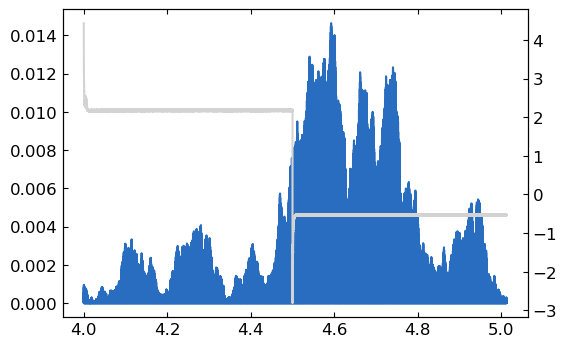

In [359]:
idx = pulse_idx[1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(tt[idx:idx+1500000], zz_bp[idx:idx+1500000]**2, color=yale_colors[1])
ax.twinx().plot(tt[idx:idx+1500000], dd[idx:idx+1500000], color='lightgrey')

Calculate ensemble averaged variance

In [3]:
# Because of data corruption we end up only have 327 time traces...
window_length = 1500000
var_all = []
for file in data_files:
    dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
    fs = int(np.ceil(1/dtt))
    
    # For some reason a lot of data are corrupted,
    # manually pick them out here
    if fs == 1:
        continue

    dd = nn[1]
    zz = nn[0]
    zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)
    
    pulse_idx = drive_indices = utils.get_pulse_idx(dd, 1, True)
    for idx in pulse_idx:
        if idx > tt.size-window_length:
            continue
        var_all.append(zz_bp[idx:idx+window_length]**2)
        
var_all = np.asarray(var_all)

In [296]:
window_length = 1500000

dtt = 6.75e-7
c_mv = 5.565e-08

var_mean = np.mean(var_all, axis=0)
var_std = np.std(var_all, axis=0)
var_mean_lp = utils.lowpass_filtered(var_mean, int(np.ceil(1/dtt)), 1000)

# Get the linear part and fit for recoil heating rate
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b

lb, ub = 100000, window_length-600000
tt_fit = np.arange(start=0, stop=dtt*window_length, step=dtt)[lb:ub]
var_mean_fit = var_mean[lb:ub] * c_mv**2

popt, pcov = curve_fit(func, tt_fit, var_mean_fit)

## TODO: estimate error of the fitted heating rate

In [297]:
gamma_reheating = 0.5 * m * omega0**2 * popt[0] / (hbar * omega0)
# gamma_reheating_err = 0.5 * m * omega**2 *  / (hbar * omega0)
print(f'Measured heating rate: {gamma_reheating/(2*np.pi*1000):.1f} \pm {gamma_reheating_err/(2*np.pi*1000):.1f} kHz')

Measured heating rate: 6.4 \pm 0.0 kHz


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/1454398095.py:3: SyntaxWarning: invalid escape sequence '\p'
  print(f'Measured heating rate: {gamma_reheating/(2*np.pi*1000):.1f} \pm {gamma_reheating_err/(2*np.pi*1000):.1f} kHz')


<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/3722049985.py:5: SyntaxWarning: invalid escape sequence '\G'
  ax.plot(tt_fit*1000, func(tt_fit, *popt), 'r', label='Fitted heating rate\n$\Gamma_{\mathrm{tot}} = (2 \pi) \\times 6.4$ kHz')


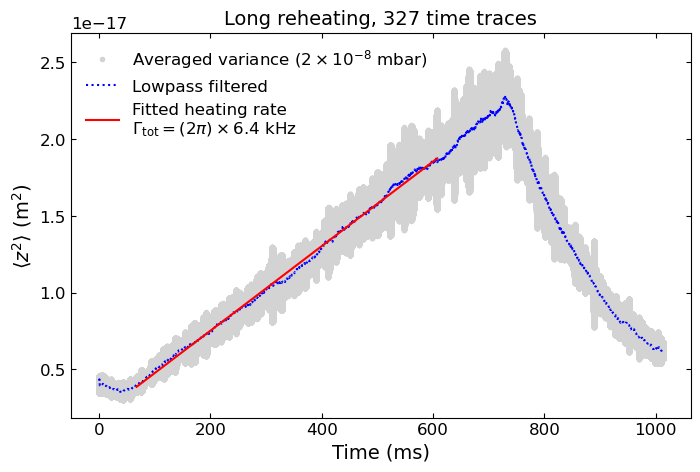

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(np.arange(start=0, stop=dtt*window_length, step=dtt)*1000, var_mean*c_mv**2, '.', color='lightgrey', label=r'Averaged variance ($2 \times 10^{-8}$ mbar)')
ax.plot(np.arange(start=0, stop=dtt*window_length, step=dtt)[1000:]*1000, var_mean_lp[1000:]*c_mv**2, ':', color='blue', label='Lowpass filtered')
ax.plot(tt_fit*1000, func(tt_fit, *popt), 'r', label='Fitted heating rate\n$\Gamma_{\mathrm{tot}} = (2 \pi) \\times 6.4$ kHz')

ax.set_title('Long reheating, 327 time traces')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel(r'$\langle z^2 \rangle$ (m$^2$)', fontsize=14)
ax.legend(frameon=False)

Text(0, 0.5, 'V$^2$')

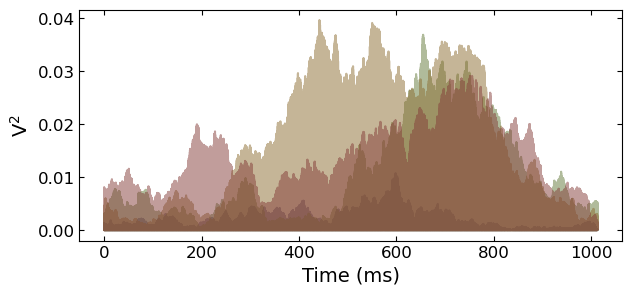

In [150]:
for i in range(4):
    plt.plot(np.arange(start=0, stop=dtt*window_length, step=dtt)*1000, var_all[i], alpha=0.5)
    
plt.xlabel('Time (ms)')
plt.ylabel('V$^2$')

## Estimate imprecision and backaction noise

In [276]:
zpf = np.sqrt(hbar / (2 * m * omega0))

S_ff_ba = hbar**2 * gamma_reheating / (zpf**2)  # N^2 / Hz
S_zz_imp = (zpf**2) / (4 * gamma_reheating)     # m^2 / Hz

In [277]:
def get_c_d_integrals(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    
    return C, D

def calc_geometric_factor(na):
    """Calculate the geometric factor A using Eq. (A3)(, E2a) and (E2b) of https://arxiv.org/pdf/1907.12838.pdf"""
    C, D = get_c_d_integrals(na)
    return D / C

na = 0.77
lambd = 1064e-9
k = 2 * np.pi / lambd

A = calc_geometric_factor(na=na)
p_sca = S_ff_ba / ((A**2 + 2/5) * hbar * k / c)

print(f'Scattered laser power = {p_sca*1e6:.2f} uW')
print(f'Backaction noise] (one-sided): {S_ff_ba * 2:.3e} N^2/Hz')
print(f'Imprecision noise floor (one-sided): {S_zz_imp * 2:.3e} m^2/Hz')

Scattered laser power = 7.24 uW
Backaction noise] (one-sided): 2.063e-40 N^2/Hz
Imprecision noise floor (one-sided): 2.129e-27 m^2/Hz


In [290]:
# Always integrate over double-sided spectra to avoid confusion...
# also numerical integration over one-sided spectra gives incorrect values sometimes
# look into more in the future
omega = np.linspace(-2*300e3*np.pi, 2*300e3*np.pi, 10000)

pi = np.pi
zpf = np.sqrt(hbar / (2 * m * omega0))  # Zero point fluctuation (m)

omegaz = omega0

# gamma = damping_photon * 1e8
gamma = 1 * 2 * np.pi

# ZPF
S_zz_zpf = 0.5 * zpf**2 * gamma / ( (omega-omega0)**2 + (gamma/2)**2 )

chi = (1 / m) / (omega0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility
S_zz_tot = np.full_like(omega, S_zz_imp) + S_ff_ba * np.abs(chi) * np.abs(chi) + S_zz_zpf

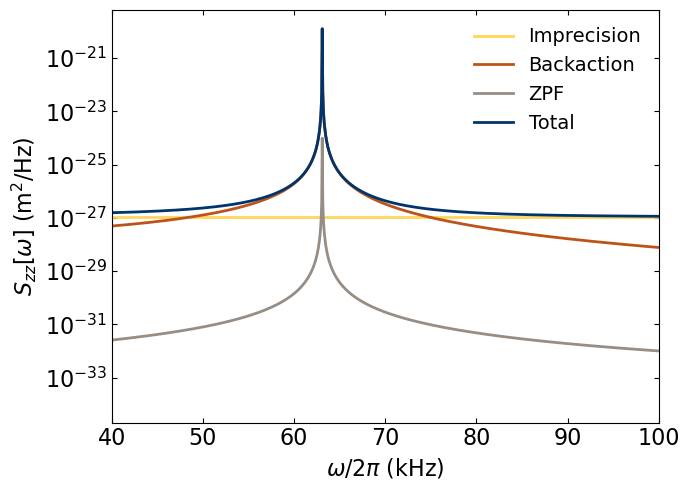

In [291]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(omega/(1000*2*pi), np.full_like(omega, S_zz_imp), label='Imprecision', color='#ffd55a', linewidth=2)
ax.plot(omega/(1000*2*pi), S_ff_ba * np.abs(chi) * np.abs(chi), label='Backaction', color='#bd5319', linewidth=2)
ax.plot(omega/(1000*2*pi), S_zz_zpf, label='ZPF', color='#978d85', linewidth=2)
ax.plot(omega/(1000*2*pi), S_zz_tot, label='Total', alpha=1, color='#00356b', linewidth=2)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlim(40, 100)
ax.set_yscale('log')
ax.set_xlabel(r'$\omega / 2 \pi$ (kHz)', fontsize=16)
ax.set_ylabel(r'$S_{zz}[\omega]$ (m$^2$/Hz)', fontsize=16)
ax.legend(frameon=False, fontsize=14)

plt.tight_layout()

<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\o'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/2514955302.py:20: SyntaxWarning: invalid escape sequence '\e'
  ax.text(45, 1e-37, f'Total force noise:\n{delta_p_kev:.1f} kev/c ($\eta = 1$), {delta_p_kev_real:.1f} kev/c ($\eta = {eta:.2f}$)', fontsize=14)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/2514955302.py:20: SyntaxWarning: invalid escape sequence '\e'
  ax.text(45, 1e-37, f'Total force noise:\n{delta_p_kev:.1f} kev/c ($\eta = 1$), {delta_p_kev_real:.1f} kev/c ($\eta = {eta:.2f}$)', fontsize=14)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/2514955302.py:24: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Single-

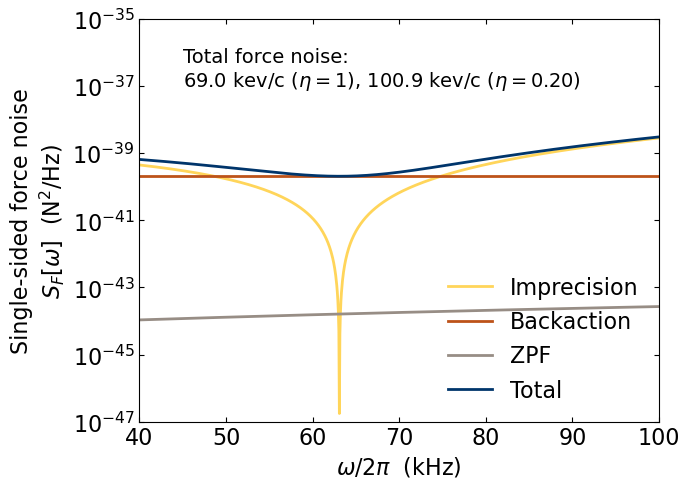

In [294]:
fig, ax = plt.subplots(figsize=(7, 5))

S_ff_imp = S_zz_imp / (np.abs(chi) * np.abs(chi))
S_ff_bac = np.full_like(omega, S_ff_ba)
S_ff_zpf = S_zz_zpf / (np.abs(chi) * np.abs(chi))

eta = 0.2
S_ff_tot = (S_ff_imp + S_ff_bac + S_ff_zpf)
S_ff_tot_real = (S_ff_imp/eta + S_ff_bac + S_ff_zpf)

ax.plot(omega/(1000*2*pi), 2*S_ff_imp, label='Imprecision', linewidth=2, color='#ffd55a')
ax.plot(omega/(1000*2*pi), 2*S_ff_bac, label='Backaction', linewidth=2, color='#bd5319')
ax.plot(omega/(1000*2*pi), 2*S_ff_zpf, label='ZPF', linewidth=2, color='#978d85')
ax.plot(omega/(1000*2*pi),  S_f_tot, label='Total', linewidth=2, color='#00356b')

# Times two during integral because we're integrating over only positive frequency
delta_p_kev = np.sqrt( 1/( np.trapz(1/(S_ff_tot), x=omega)/(2*np.pi) ) ) * SI2ev / 1000
delta_p_kev_real = np.sqrt(1/(np.trapz(1/(S_ff_tot_real), x=omega)/(2*np.pi))) * SI2ev / 1000

ax.text(45, 1e-37, f'Total force noise:\n{delta_p_kev:.1f} kev/c ($\eta = 1$), {delta_p_kev_real:.1f} kev/c ($\eta = {eta:.2f}$)', fontsize=14)

ax.set_yscale('log')
ax.set_xlabel(r'$\omega / 2 \pi$  (kHz)', fontsize=16)
ax.set_ylabel('Single-sided force noise\n$S_{F}[\omega] \ \ $($\mathrm{N}^2/\mathrm{Hz}$)', fontsize=16)
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)

ax.set_xlim(40, 100)
ax.set_ylim(1e-47, 1e-35)
ax.legend(frameon=False, fontsize=16, loc='lower right')

plt.tight_layout()

## Repeat analysis on short reheating data

In [360]:
folder = r'/Users/yuhan/work/nanospheres/data/20241002_reheating'
dataset = r''
combined_path = os.path.join(folder, dataset, '20241002*.mat')
data_files = glob.glob(combined_path)

Quick look on the data, and choose an appropriate time window

In [361]:
file = data_files[5]
dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
fs = int(np.ceil(1/dtt))

dd = nn[1]
zz = nn[0]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

pulse_idx = drive_indices = utils.get_pulse_idx(dd, 1, True)

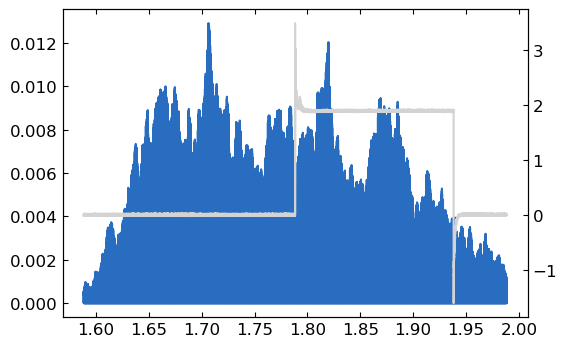

In [366]:
window_length = 1000000
idx = pulse_idx[3]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(tt[idx-window_length:idx+window_length], zz_bp[idx-window_length:idx+window_length]**2, color=yale_colors[1])
ax.twinx().plot(tt[idx-window_length:idx+window_length], dd[idx-window_length:idx+window_length], color='lightgrey')

In [310]:
window_length = 1000000
var_all_short = []
for file in data_files:
    dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
    fs = int(np.ceil(1/dtt))
    
    if fs == 1:
        continue

    dd = nn[1]
    zz = nn[0]
    zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)
    
    pulse_idx = drive_indices = utils.get_pulse_idx(dd, 1, True)
    for idx in pulse_idx:
        if idx > tt.size-0.6*window_length or idx < 0.4*window_length:
            continue
        var_all_short.append(zz_bp[idx-int(0.4*window_length):idx+int(0.6*window_length)]**2)
        
var_all_short = np.asarray(var_all_short)

In [311]:
var_all_short.shape

(1069, 1000000)

In [312]:
window_length = 1000000
dtt = 2e-7
c_mv = 5.565e-08

var_mean_short = np.mean(var_all_short, axis=0)
var_std_short = np.std(var_all_short, axis=0)
var_mean_short_lp = utils.lowpass_filtered(var_mean_short, int(np.ceil(1/dtt)), 1000)

In [354]:
lb, ub = 125000, window_length-220000
tt_short_fit = np.arange(start=0, stop=dtt*window_length, step=dtt)[lb:ub]
var_mean_short_fit = var_mean_short[lb:ub] * c_mv**2

popt, pcov = curve_fit(func, tt_short_fit, var_mean_short_fit, p0=[var_mean_short_fit[-1]/tt_short_fit[-1], 0])

In [355]:
gamma_reheating_short = 0.5 * m * omega0**2 * popt[0] / (hbar * omega0)
# gamma_reheating_err = 0.5 * m * omega**2 *  / (hbar * omega0)
print(f'Measured heating rate: {gamma_reheating_short/(2*np.pi*1000):.1f} \pm {gamma_reheating_err/(2*np.pi*1000):.1f} kHz')

Measured heating rate: 4.6 \pm 0.0 kHz


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/1204155556.py:3: SyntaxWarning: invalid escape sequence '\p'
  print(f'Measured heating rate: {gamma_reheating_short/(2*np.pi*1000):.1f} \pm {gamma_reheating_err/(2*np.pi*1000):.1f} kHz')


<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1500/1693365244.py:5: SyntaxWarning: invalid escape sequence '\G'
  ax.plot(tt_short_fit*1000, func(tt_short_fit, *popt), 'r', label='Fitted heating rate\n$\Gamma_{\mathrm{tot}} = (2 \pi) \\times 4.6$ kHz')


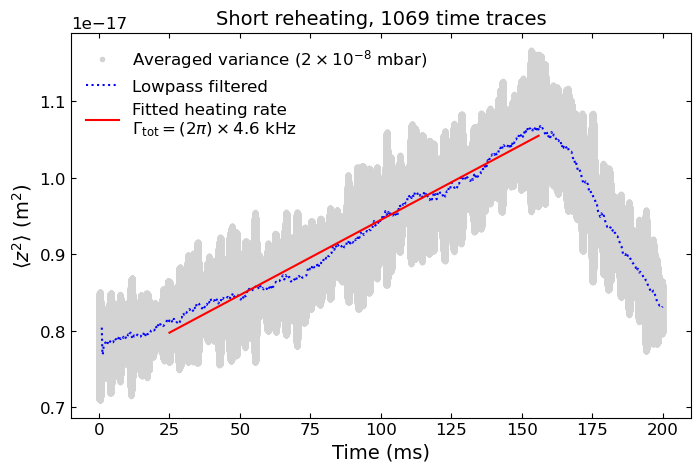

In [356]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(np.arange(start=0, stop=dtt*window_length, step=dtt)*1000, var_mean_short*c_mv**2, '.', color='lightgrey', label=r'Averaged variance ($2 \times 10^{-8}$ mbar)')
ax.plot(np.arange(start=0, stop=dtt*window_length, step=dtt)[5000:]*1000, var_mean_short_lp[5000:]*c_mv**2, ':', color='blue', label='Lowpass filtered')
ax.plot(tt_short_fit*1000, func(tt_short_fit, *popt), 'r', label='Fitted heating rate\n$\Gamma_{\mathrm{tot}} = (2 \pi) \\times 4.6$ kHz')

ax.set_title('Short reheating, 1069 time traces')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel(r'$\langle z^2 \rangle$ (m$^2$)', fontsize=14)
ax.legend(frameon=False)